In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from matplotlib import colorbar, colors
import os
from datetime import datetime, timedelta
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

plt.rcParams['legend.fontsize'] = 10
plt.rcParams.update({'figure.autolayout': True})

## Strain rate field by least-square collocation method

### Compute velocity from ELTM coefficients
The non-periodic component of east or north displacement, $u$, as a function of the number of days from 2011/04/11, is expressed in terms of the 11 ELTM coefficients:

$
\mathbf{u}(d) = (p d + q) +
\left( \mathbf{s}_{a}\sin(\omega_{a}d) + \mathbf{c}_{a}\cos(\omega_{a}d) \right) +
\left( \mathbf{s}_{h}\sin(\omega_{h}d) + \mathbf{c}_{h}\cos(\omega_{h}d) \right) +
a\log(1+\Delta d_{m}/T_{m}).
$

$ u(d) = pd + q + a\log\left( 1+\frac{2(d+21)}{365} \right) $, where $p$, $q$ and $a$ are 0-, 1- and 10-th coefficients, and 21 is the number of days since the March 11, 2011 Tohoku earthquake until Apritl 1, 2011.

Velocity can be derived as 
$ v(d) = p + \frac{ka}{1+k(d+21)}$, where $k = 2/365$ (i.e., the inverse of half a year).

### Loading Data
If a pickled data object exists, load and use it as an instance of `GPS_Stations` class named `Korea_GPS_Stations`.
The loaded pickle file should contain 55 stations.


In [2]:
try: 
    with open( 'Korea_GPS_Stations_coeff_cov_20110401_20161231.p', 'rb' ) as handle:
        Korea_GPS_CoeffCov = pickle.load(handle)
        # This is a dictionary with 55 stations as keys
        # Each item is a dictionary with 4 keys, ecoeff, ecov, ncoeff, ncov.
        print(Korea_GPS_CoeffCov['DAEJ']['ecoeff'])
except: # FileNotFoundError:
    print("Failed to load the pickled data. Generate ELTM coefficients using GPSdata.ipynb.")

[ 7.52111858e-05 -4.58546762e-03 -1.38652875e-03 -1.80878108e+01
  4.76382753e-03  8.47243846e+01 -7.19859033e-04 -2.21753202e+01
 -1.13390811e-03 -3.81648540e+01  3.26937210e-03]


### Compute $\mathbf{M}$ matrix for each point
A strain rate tensor ($\boldsymbol{\varepsilon}$) at a location is the spatially linear rate of change of velocity at that location. In other words, velocity at a GPS station ($\mathbf{v}$) can be approximated as the sum of a translation vector, $\mathbf{t}$, and the product of strain rate and $\mathbf{X} = \mathbf{x}^{(i)} - \mathbf{x}$, where $\mathbf{x}^{(i)}$ is the position vector of the $i$-th station and $\mathbf{x}$ is the current location of interest:
$ \mathbf{t} + \boldsymbol{\varepsilon} \mathbf{X} = \mathbf{v}$.

Since we have multiple GPS stations and cannot expect the relationship to hold exactly for all of them, we try to find $\mathbf{t}$ and $\boldsymbol{\varepsilon}$ in the least square sense.
$ \mathbf{t}^{(i)} + \boldsymbol{\varepsilon} \mathbf{X}_{i}^{(i)} = \mathbf{v}^{(i)}$, where $\mathbf{X}^{(i)}$ is the position vector of the $i$-th GPS station minus the position vector of a grid point, and $\mathbf{v}^{(i)}$ is the GPS velocity at the $i$-th station ($i=1,\ldots,n$).

$
\begin{bmatrix}
1 & 0 & X_{1}^{(1)} & X_{2}^{(1)} & 0 & 0 \\
0 & 1 & 0 & 0 & X_{1}^{(1)} & X_{2}^{(1)} \\
1 & 0 & X_{1}^{(2)} & X_{2}^{(2)} & 0 & 0 \\
0 & 1 & 0 & 0 & X_{1}^{(2)} & X_{2}^{(2)} \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
1 & 0 & X_{1}^{(n)} & X_{2}^{(n)} & 0 & 0 \\
0 & 1 & 0 & 0 & X_{1}^{(n)} & X_{2}^{(n)}
\end{bmatrix}
\begin{bmatrix}
t_{1} \\
t_{2} \\
\varepsilon_{11} \\
\varepsilon_{12} \\
\varepsilon_{21} \\
\varepsilon_{22}
\end{bmatrix}
=
\begin{bmatrix}
v_{1}^{(1)} \\
v_{2}^{(1)} \\
v_{1}^{(2)} \\
v_{2}^{(2)} \\
\vdots \\
v_{1}^{(n)} \\
v_{2}^{(n)} \\
\end{bmatrix}
$

Putting the above relationship in the form of $\mathbf{M}\mathbf{x} = \mathbf{y}$, we invert it for $\mathbf{x}$ as follows:

$\mathbf{x} = \left( \mathbf{M}^{T}\mathbf{W}\mathbf{M} \right)^{-1} \mathbf{M}^{T}\mathbf{W} \mathbf{y}$, 
where $\mathbf{W}$ is a diagonal matrix of weighting factors.
Among many possible choices for $\mathbf{W}$, we choose the Gaussian function of distance:

$ W = \exp \left( -\frac{(d^{(i)})^{2}}{2\alpha^{2}} \right)$, where $d^{(i)}$ is the distance from a location to the $i$-th GPS station and $\alpha$ is a distance weighting constant of 40 km.


### Generate a grid of points

In [3]:
ngridpts = 51
lons = np.linspace(125.0, 131.0, ngridpts)
lats = np.linspace(33.0, 38.5, ngridpts)
long, latg = np.meshgrid(lons, lats)
positions = np.vstack([long.ravel(), latg.ravel()]).transpose()
positions.shape

(2601, 2)

### Load station locations

In [4]:
try: 
    with open( 'Korea_GPS_Stations_locations.p', 'rb' ) as handle:
        Korea_GPS_Locations = pickle.load(handle)
        # This is a dictionary with 55 stations as keys
        # Each item is a lenth-2 numpy array.
        print(Korea_GPS_Locations['DAEJ'])
except FileNotFoundError:
    print("Failed to load the pickled data. Generate ELTM coefficients using GPSdata.ipynb.")

[127.374  36.399]


### Define functions for the main tasks

In [5]:
def get_M_W( position, Korea_GPS_CoeffCov, Korea_GPS_Locations ):
    # Since v vector follows the order of stations stored in CoeffCov,
    # we loop over the station keys in CoeffCov to keep the order consistent. 
    nstations = len(Korea_GPS_CoeffCov.keys())
    M = np.zeros((2*nstations, 6))
    W = np.eye(2*nstations)
    counter = 0
    alpha_sq = 4.0e4**2 # (40 km)^2
     
#    from pyproj import Geod
#    geod = Geod(ellps="WGS84")
    from pyproj import Proj
#     if position[0] >= 120.0 and position[0] < 126.0:
#         utm_zone = 51
#     elif position[0] >= 126.0 and position[0] < 132.0:
#         utm_zone = 52
    utm_zone = 52
    p = Proj(proj='utm',zone=utm_zone, ellps='WGS84', preserve_units=False)
    # Convert position lon lat to UTM coordi   nates
    pos_x, pos_y = p(position[0], position[1])
    
    for station in Korea_GPS_CoeffCov.keys():
#         # Attempt 1: Compute geodesic distance from 'position' to station
#         lons = [pos_lon, station_lon]
#         lats = [pos_lat, station_lat]
#         d = geod.line_length(lons, lats)
#         # calcalate W value for this station
#         Wval = np.exp(-0.5*d**2/alpha_sq)
#         # compute along-latitude distance from 'position' to station
#         lons = [pos_lon, station_lon]
#         lats = [pos_lat, pos_lat]
#         X1 = geod.line_length(lons, lats)
#         # compute along-longitude distance from 'position' to station
#         lons = [pos_lon, pos_lon]
#         lats = [pos_lat, station_lat]
#         X2 = geod.line_length(lons, lats)

        # Convert station lon lat to UTM Coordinates
        station_x, station_y = p( Korea_GPS_Locations[station][0], Korea_GPS_Locations[station][1])
        # Compute distances using UTM coordinates
        X1 = station_x - pos_x
        X2 = station_y - pos_y
        d2 = X1**2 + X2**2
        #print(X1, X2, np.sqrt(d2))
        
        # Calcalate W value for this station
        Wval = np.exp(-0.5*d2/alpha_sq)
        
        # Populate M and W.
        M[2*counter,:] = [1.0, 0.0, X1, X2, 0.0, 0.0]
        M[2*counter+1,:] = [0.0, 1.0, 0.0, 0.0, X1, X2]
        W[2*counter,2*counter] = Wval
        W[2*counter+1,2*counter+1] = Wval
        counter = counter + 1
        
    return M, W

def get_eps_omega( M, W, vel_vector ):
    # Solve Ax = b
    tmpA = np.matmul(np.transpose(M), W)
    A = np.matmul( tmpA, M )
    b = np.dot(tmpA, vel_vector)
    # Take only the velocity gradient and reshape it to 2x2 matrix.
    vgrad = np.linalg.solve(A,b)[2:].reshape((2,2))
    eps = 0.5*(vgrad+np.transpose(vgrad))
    omega = 0.5*(vgrad-np.transpose(vgrad))
    return eps, omega

### Generate velocity vector from the ELTM coefficients

In [6]:
def get_velocities( Korea_GPS_CoeffCov, d ):
    velocities = {}
    k = 2.0/365.0 # 1 over 0.5 year.
    for station in Korea_GPS_CoeffCov.keys():
        p = Korea_GPS_CoeffCov[station]['ecoeff'][0]
        a = Korea_GPS_CoeffCov[station]['ecoeff'][10]
        ve = p + k*a/(1.0+k*(d+21.0))
        p = Korea_GPS_CoeffCov[station]['ncoeff'][0]
        a = Korea_GPS_CoeffCov[station]['ncoeff'][10]
        vn = p + k*a/(1.0+k*(d+21.0))
        velocities[station] = np.array([ve,vn])
    return velocities

def get_vel_vector( vel ):
    vel_vector = np.zeros( 2*len(vel.keys()) )
    counter = 0
    for s in vel.keys():
        vel_vector[2*counter] = vel[s][0]
        vel_vector[2*counter+1] = vel[s][1]
        counter = counter + 1
    return vel_vector

### Get strain rates and rotation at every grid point

In [7]:
# for 5 years, 2011/4/11-2016/4/10
nyears = 2
vel_vector_annual = np.zeros( (nyears, 2*len(Korea_GPS_CoeffCov.keys())) )

for yr in np.arange(nyears):
    # get vel velctor for April 12, 2011, one day after 04/11.
    if yr == 0:
        first_day = 365*yr + 1
        last_day = 365*(yr+2)
    else:
        first_day = 365*(yr+1) + 1
        last_day = 365*(yr+4)
    for d in np.arange(first_day, last_day+1):
        vel = get_velocities( Korea_GPS_CoeffCov, d)
        #rint(vel['DAEJ'])
        vel_vector_annual[yr,:] += get_vel_vector( vel )
    vel_vector_annual[yr,:] /= 365.0
    

In [8]:
COMPUTE_KINEMATICS = False
try: 
    with open( 'annual_mean_dilation_2_3.p', 'rb' ) as handle:
        # This is an array of (5, ngridpts, ngridpts)
        eps_k_annual = pickle.load(handle)
except: # FileNotFoundError:
    print("Failed to load the pickled dilation rate data.\n\
    It might be necessary to re-generate kinematic variables.")
    COMPUTE_KINEMATICS = True

try: 
    with open( 'annual_mean_maxshear_2_3.p', 'rb' ) as handle:
        # This is an array of (5, ngridpts, ngridpts)
        eps_max_annual = pickle.load(handle)
except: # FileNotFoundError:
    print("Failed to load the pickled max shear strain rate data.\n\
    It might be necessary to re-generate kinematic variables.")
    COMPUTE_KINEMATICS = True

try: 
    with open( 'annual_mean_omega_2_3.p', 'rb' ) as handle:
        # This is an array of (5, ngridpts, ngridpts)
        omega_annual = pickle.load(handle)
except: # FileNotFoundError:
    print("Failed to load the pickled rigid-body rotation rate data.\n\
    It might be necessary to re-generate kinematic variables.")
    COMPUTE_KINEMATICS = True    

In [9]:
if COMPUTE_KINEMATICS:
    eps_k_annual   = np.zeros( (nyears, ngridpts, ngridpts) )
    eps_max_annual = np.zeros( (nyears, ngridpts, ngridpts) )
    omega_annual   = np.zeros( (nyears, ngridpts, ngridpts) )

    for yr in range(nyears):
        for i, lat in enumerate(lats):
            for j, lon in enumerate(lons):
                M, W = get_M_W( np.array([lon, lat]), Korea_GPS_CoeffCov, Korea_GPS_Locations )  
                eps, omg = get_eps_omega( M, W, vel_vector_annual[yr,:] )

                D, V = scipy.linalg.eigh(eps)
                # principal strain rate
                eps_p = D
                eps_p_map1 = eps_p[0]*V[:,0]
                eps_p_map2 = eps_p[1]*V[:,1]
                # dilation
                eps_k_annual[yr, i, j] = eps_p[0]+eps_p[1]
                # max shear strain rate
                eps_max_annual[yr, i, j] = abs(eps_p[0]-eps_p[1])
                # rigid-body rotation
                omega_annual[yr, i, j] = omg[0,1]
    #             print(yr, i, j)
    with open('annual_mean_dilation_2_3.p', 'wb') as handle:
        pickle.dump(eps_k_annual, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('annual_mean_maxshear_2_3.p', 'wb') as handle:
        pickle.dump(eps_max_annual, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('annual_mean_omega_2_3.p', 'wb') as handle:
        pickle.dump(omega_annual, handle, protocol=pickle.HIGHEST_PROTOCOL)
    COMPUTE_KINEMATICS = False

In [10]:
def plot_variable( long, latg, variable, varname, varsymbol, unit, year, cmap, vmin, vmax, fname='testplot.pdf' ):
    fig = plt.figure()
    fig.set_figheight(4)
    fig.set_figwidth(4)

    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) #stamen_terrain.crs)
    ax1.set_extent([126, 129.75, 34, 38.5], crs=ccrs.PlateCarree())
    # 365.0 is multiplied to convert 1/day to 1/year
    plotvar = ax1.contourf(long, latg, variable*365.0, 120, cmap=cmap, \
                 transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, zorder=0)
    ax1.contour(long, latg, variable*365.0, 30, colors='black', \
                 transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, zorder=1)
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m', \
                                                 edgecolor='face', facecolor='white'), zorder=2)
    # ax1.add_feature(cfeature.OCEAN, facecolor='white', zorder=1)
    ax1.add_feature(cfeature.COASTLINE, color='white', linewidth=2, zorder=3)
    if year == 0:
        title = "{0} ({1:d}.4 - {2:d}.4)".format(varsymbol, 2011, 2013)
    else:
        title = "{0} ({1:d}.4 - {2:d}.4)".format(varsymbol, 2013, 2016)
    ax1.set_title(title, fontsize=16)

    #get size and extent of axes:
    axpos = ax1.get_position()
    pos_x = axpos.x0 + axpos.width + 0.15*axpos.width
    pos_y = axpos.y0
    cax_width = 0.05
    cax_height = axpos.height
    #create new axes where the colorbar should go.
    #it should be next to the original axes and have the same height!
    pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
    cbar = colorbar.ColorbarBase(pos_cax, cmap=plt.get_cmap(cmap), \
        norm=colors.Normalize(vmin=vmin, vmax=vmax)) # set min, max of colorbar
    cbar.set_label(varname+' ('+varsymbol+', '+unit+')', fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    
    gl = ax1.gridlines(draw_labels=True, color='gray', zorder=10)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([125, 126, 127, 128, 129, 130, 131])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator([34, 35, 36, 37, 38])
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    
    fig.savefig(fname, facecolor='white', bbox_inches="tight")
    

C:\Users\eddy_\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Users\eddy_\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\eddy_\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


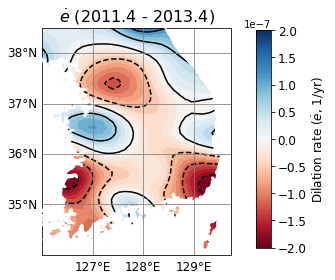

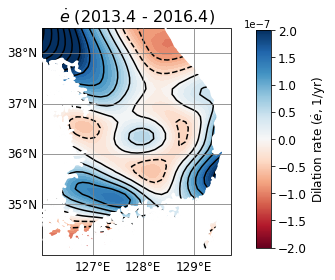

In [11]:
# camp: turbo, seismic, coolwarm, rainbow, RdBu
#long, latg, variable, varname, varsymbol, year, cmap, vmin, vmax, fname='testplot.pdf' ):
for yr in range(2):
    plot_variable(long, latg, eps_k_annual[yr,:,:], "Dilation rate", \
                  r'$\dot{e}$', '1/yr', yr, 'RdBu', \
                  -2e-7, 2e-7, './dilation_2_3_yr{0:d}.png'.format(yr))

C:\Users\eddy_\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


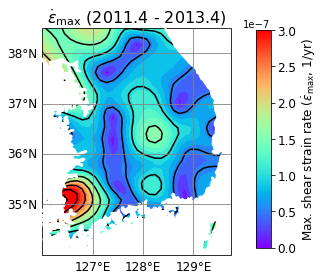

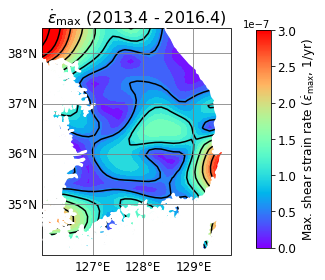

In [18]:
# camp: turbo, seismic, coolwarm, rainbow, RdBu
#long, latg, variable, varname, varsymbol, year, cmap, vmin, vmax, fname='testplot.pdf' ):
for yr in range(2):
    plot_variable(long, latg, eps_max_annual[yr,:,:], "Max. shear strain rate", \
                  r'$\dot{\varepsilon}_{\mathrm{max}}$', '1/yr', yr, 'rainbow', \
                  0.0, 3e-7, './maxshear_2_3_yr{0:d}.png'.format(yr))

In [46]:
np.min(omega_annual[0,:,:])

-5.274973878747755e-10

C:\Users\eddy_\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


OSError: [Errno 22] Invalid argument: './omega_2_3_yr1.png'

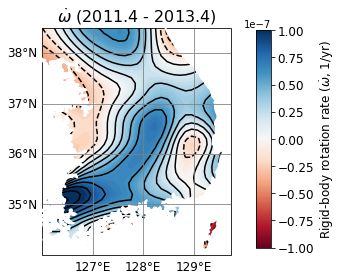

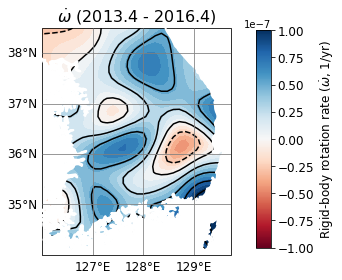

In [23]:
# camp: turbo, seismic, coolwarm, rainbow, RdBu
#long, latg, variable, varname, varsymbol, year, cmap, vmin, vmax, fname='testplot.pdf' ):
for yr in range(2):
    plot_variable(long, latg, omega_annual[yr,:,:], "Rigid-body rotation rate", \
                  r'$\dot{\omega}$', '1/yr', yr, 'RdBu', \
                  -1e-7, 1e-7, './omega_2_3_yr{0:d}.png'.format(yr))

AttributeError: 'AxesSubplot' object has no attribute 'set_extent'

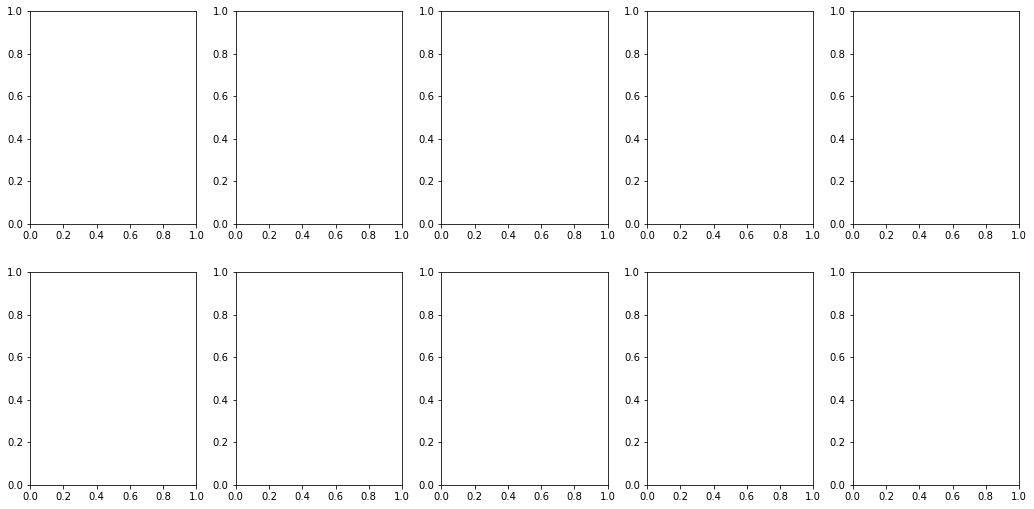

In [40]:
nrow = 2
ncol = 5
fig, axes = plt.subplots(ncols=ncol, nrows=nrow, constrained_layout=True)
fig.set_figheight(9)
fig.set_figwidth(18)

for r in range(nrow):
    for c in range(ncol):
        plotnum = c + ncol*r + 1
        ax = axes[r,c] #fig.add_subplot(nrow, ncol, plotnum, projection=ccrs.PlateCarree()) #stamen_terrain.crs)
        ax.set_extent([125, 131, 33, 38.5], crs=ccrs.PlateCarree())
        ax.set_aspect(1)
        ax.coastlines(resolution='10m', linewidth=2)
        ax.add_feature(cfeature.OCEAN)
        #ax1 = plt.axes(projection=ccrs.PlateCarree())
        if r==0:
            dilation = ax.contourf(long, latg, eps_k_annual[c,:,:], 60, cmap='Spectral', \
                         transform=ccrs.PlateCarree(), vmin=-0.3e-9, vmax=0.3e-9)
            plotvar = r'$\dot{e}$'
            ax.set_title(plotvar+" {0:d}.4-{1:d}.4".format(2011+c, 2011+c+1), fontsize=22)
            if c == ncol-1:
                #get size and extent of axes:
                axpos = ax.get_position()
                pos_x = axpos.x0 + axpos.width + 0.25*axpos.width
                pos_y = axpos.y0
                cax_width = 0.02
                cax_height = axpos.height
                #create new axes where the colorbar should go.
                #it should be next to the original axes and have the same height!
                pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
                cbar = plt.colorbar(dilation, cax=pos_cax)
                #cbar.set_clim(-0.25e-9,0.25e-9)
        else:
            emax = ax.contourf(long, latg, eps_max_annual[c,:,:], 60, cmap='jet', #gist_rainbow',
                         transform=ccrs.PlateCarree(), vmin=0.0, vmax=0.5e-9)
            plotvar = r'$\dot{\varepsilon}_{\mathrm{max}}$'
            ax.set_title(plotvar+" {0:d}.4-{1:d}.4".format(2011+c, 2011+c+1), fontsize=22)
            if c == ncol-1:
                #get size and extent of axes:
                axpos = ax.get_position()
                pos_x = axpos.x0 + axpos.width + 0.25*axpos.width
                pos_y = axpos.y0
                cax_width = 0.02
                cax_height = axpos.height
                #create new axes where the colorbar should go.
                #it should be next to the original axes and have the same height!
                pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
                cbar = plt.colorbar(emax, cax=pos_cax)
                #cbar.set_clim(-0.25e-9,0.25e-9)
        

plt.show()